

# AF Visão computacional - Detecção de Objetos

* Davi Oliveira da Silva - 200913
* Gabriel Lucas Pinheiro de Arruda - 200840
* Lucas Marthe de Almeida - 200567

<hr>

## 1 - Import e criaçao do ambiente

In [ ]:
from google.colab import files
import os
import pandas as pd
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from torchvision.ops import box_iou
import random

Trecho onde permite o download do dataset no kaggle

In [ ]:
files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/tomato-detection

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/tomato-detection
License(s): CC0-1.0
100% 180M/180M [00:09<00:00, 22.8MB/s]
100% 180M/180M [00:09<00:00, 19.5MB/s]


In [ ]:
# Verificação de GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Usando dispositivo: {device}')

Usando dispositivo: cuda


Extrai o dataset

In [ ]:
import zipfile
with zipfile.ZipFile('tomato-detection.zip', 'r') as zip_ref:
  zip_ref.extractall('./tomato')

## 2 - Análise dos dados

Cria um dataframe usando o dataset baixado

In [ ]:
images_paths = ["./tomato/images/" + img for img in os.listdir("./tomato/images")]
labels_paths = ["./tomato/annotations/" + lbl for lbl in os.listdir("./tomato/annotations")]

images_paths.sort()
labels_paths.sort()

data = {'Images' : images_paths , "Labels" : labels_paths}
paths = pd.DataFrame(data)
print(paths.head())

                          Images                              Labels
0    ./tomato/images/tomato0.png    ./tomato/annotations/tomato0.xml
1    ./tomato/images/tomato1.png    ./tomato/annotations/tomato1.xml
2   ./tomato/images/tomato10.png   ./tomato/annotations/tomato10.xml
3  ./tomato/images/tomato100.png  ./tomato/annotations/tomato100.xml
4  ./tomato/images/tomato101.png  ./tomato/annotations/tomato101.xml


Função que lê o caminho da imagem, abre ela e ainda converte para tensor

In [ ]:
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Carrega a imagem e converte para RGB
    image_tensor = ToTensor()(image)  # Converte a imagem para um tensor
    return image, image_tensor

Extrai as bounding boxes e tamanhos das imagens que estão informadas nos seus xml

In [ ]:
def parse_xml_label(label_path):
  tree = ET.parse(label_path)
  root = tree.getroot()
  size_elem = root.find('size')
  width = int(size_elem.find('width').text)
  height = int(size_elem.find('height').text)

  bounding_boxes = []
  for obj in root.findall('object'):
      bbox = obj.find('bndbox')
      xmin = int(bbox.find('xmin').text)
      ymin = int(bbox.find('ymin').text)
      xmax = int(bbox.find('xmax').text)
      ymax = int(bbox.find('ymax').text)

      bounding_boxes.append({'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

  size = (width, height)
  bounding_boxes = sorted(bounding_boxes, key=lambda x: x['ymin'])
  return size, bounding_boxes

Cria um dataframe inicial com o path das imagens, seus tamanhos e suas bounding boxes

In [ ]:
def preproccess(dataset):
  dataframe = pd.DataFrame(columns=['img', 'size', 'boxes'])

  for idx in range(len(dataset)):
    img_path = dataset.loc[idx, 'Images']
    label_path = dataset.loc[idx, 'Labels']

    # Parse the label file before resizing
    size, bounding_boxes = parse_xml_label(label_path)

    dataframe.loc[idx] = [img_path, size, bounding_boxes]

  return dataframe

In [ ]:
dataframe = preproccess(paths)


In [ ]:
dataframe.head()

,img,size,boxes
0,./tomato/images/tomato0.png,"(400, 500)","[{'xmin': 375, 'ymin': 120, 'xmax': 400, 'ymax..."
1,./tomato/images/tomato1.png,"(500, 400)","[{'xmin': 473, 'ymin': 0, 'xmax': 500, 'ymax':..."
2,./tomato/images/tomato10.png,"(400, 500)","[{'xmin': 312, 'ymin': 371, 'xmax': 400, 'ymax..."
3,./tomato/images/tomato100.png,"(400, 500)","[{'xmin': 0, 'ymin': 262, 'xmax': 58, 'ymax': ..."
4,./tomato/images/tomato101.png,"(500, 400)","[{'xmin': 68, 'ymin': 113, 'xmax': 126, 'ymax'..."


Função para plotar as imagens com as bounding boxes

In [ ]:
def plot_image_with_boxes(image, boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for idx in range(len(boxes)):
        xmin, ymin, xmax, ymax = boxes[idx]
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

Função para plotar as imagens com as bounding boxes descritas no xml

In [ ]:
def object_plot(image_path, boxes):
  # Carrega a imagem e converte para tensor
    image, image_tensor = load_image(image_path)

    boxes = [[box['xmin'], box['ymin'], box['xmax'], box['ymax']] for box in boxes]
    # Exibe a imagem com as caixas delimitadoras
    plot_image_with_boxes(image, boxes)

Função para plotar as bounding boxes que o modelo do faster r cnn previu sem nenhum treinamento

In [ ]:
#Função principal para realizar a detecção de objeto
def object_detection(image_path):
    # Carrega um modelo pré-treinado do Faster R-CNN
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()  # Coloca o modelo em modo de avaliação (inferência)

    # Carrega a imagem e converte para tensor
    image, image_tensor = load_image(image_path)

    # Coloca o tensor da imagem em uma lista e realiza a detecção
    with torch.no_grad():  # Desabilita o cálculo de gradientes (não necessário na inferência)
        predictions = model([image_tensor])

    boxes = predictions[0]['boxes'].cpu().numpy()

    plot_image_with_boxes(image, boxes)

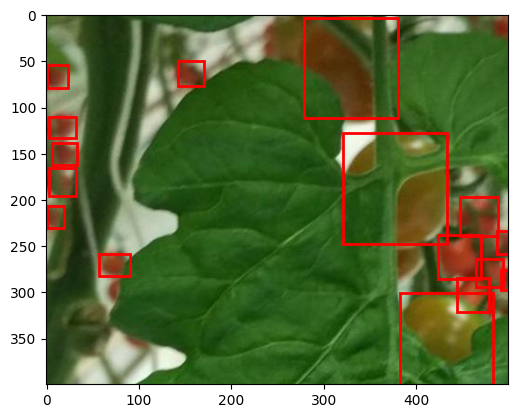

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 117MB/s]


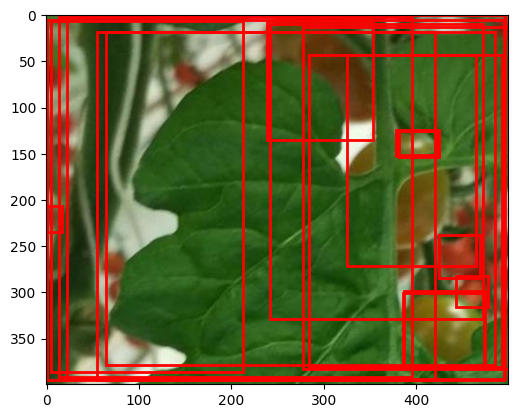

In [ ]:
randomizer = dataframe.sample(n=1)

img = randomizer['img'].iloc[0]
size = randomizer['size'].iloc[0]
boxes = randomizer['boxes'].iloc[0]

object_plot(img, boxes)
object_detection(img)

## 3 - Pré-processamento dos dados

Função que cria um dataframe manipulável para o treinamento de máquina, retorna os tensores das imagens e seus "targets"(bounding boxes e as labels das classes) em forma de dicionário

In [ ]:
def preprocessing_for_train(dataframe):
  image_tensor_t = []
  boxes_t = []

  for idx in range(len(dataframe)):
    img_path = dataframe.loc[idx, 'img']
    boxes = dataframe.loc[idx, 'boxes']
    boxes = [[box['xmin'], box['ymin'], box['xmax'], box['ymax']] for box in boxes]
    image, image_tensor = load_image(img_path)
    target = {'boxes': torch.tensor(boxes, dtype=torch.float32), 'labels': torch.ones((len(boxes),), dtype=torch.int64)}
    image_tensor_t.append(image_tensor)
    boxes_t.append(target)

  return image_tensor_t, boxes_t

In [ ]:
df_img, df_annotation = preprocessing_for_train(dataframe)
df = list(zip(df_img, df_annotation))

Separa os dataframes em dados de teste e dados de treinamento, 80% para treino e 20% para teste.
Os armazena em lotes para as próximas etapas

In [ ]:
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_dataset, test_dataset = random_split(df, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

Inicia o modelo de treinamento

In [ ]:
# Carregar o modelo pré-treinado no COCO
model = fasterrcnn_resnet50_fpn(pretrained=True)
# Substituir a camada de saída para 2 classes: fundo e tomate
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## 4 - Treinamento do Modelo

Treina o modelo alimentando ele com as imagens e os alvos(bounding boxes) do xml

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
    return total_loss / len(data_loader)

Cria o otimizador e a quantidade de épocas em que será treinado

In [ ]:
# Otimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Loop de treinamento
num_epochs = 10
for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

Epoch 1, Loss: 0.5399
Epoch 2, Loss: 0.4270
Epoch 3, Loss: 0.3636
Epoch 4, Loss: 0.3191
Epoch 5, Loss: 0.2840
Epoch 6, Loss: 0.2489
Epoch 7, Loss: 0.2303
Epoch 8, Loss: 0.2061
Epoch 9, Loss: 0.1774
Epoch 10, Loss: 0.1775


## 5 - Resultados

coloca o modelo em modo de testes e testa com os dados de treinamento

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    results = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            outputs = model(images)
            results.append(outputs)
    return results

Calcula o mAP para múltiplas classes e limiares de confiança.

In [ ]:
def calculate_map(results, targets, iou_threshold=0.5, confidence_thresholds=None):
    if confidence_thresholds is None:
        confidence_thresholds = torch.linspace(0.0, 1.0, steps=101)  # Limiar de confiança entre 0 e 1

    average_precisions = []

    for threshold in confidence_thresholds:
        all_true_positives = []
        all_false_positives = []
        all_ground_truths = 0

        for preds, truths in zip(results, targets):
            # Filtrar previsões por pontuação de confiança
            preds = {k: v[preds["scores"] >= threshold] for k, v in preds.items()}

            # Contar caixas verdadeiras
            all_ground_truths += len(truths["boxes"])

            if len(preds["boxes"]) == 0:
                all_true_positives.append(0)
                all_false_positives.append(len(preds["boxes"]))
                continue

            # Calcular IoU
            ious = box_iou(preds["boxes"], truths["boxes"])

            # Determinar True Positives e False Positives
            true_positives = torch.zeros(len(preds["boxes"]))
            matched_truths = set()

            for pred_idx, _ in enumerate(preds["scores"]):
                max_iou, truth_idx = ious[pred_idx].max(0)
                if max_iou >= iou_threshold and truth_idx.item() not in matched_truths:
                    true_positives[pred_idx] = 1
                    matched_truths.add(truth_idx.item())

            false_positives = 1 - true_positives

            all_true_positives.append(true_positives.sum().item())
            all_false_positives.append(false_positives.sum().item())

        # Calcular precisão e recall
        total_tp = sum(all_true_positives)
        total_fp = sum(all_false_positives)

        precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
        recall = total_tp / all_ground_truths if all_ground_truths > 0 else 0

        average_precisions.append(precision)

    return sum(average_precisions) / len(average_precisions) if average_precisions else 0


Teste para avaliar o mAP do modelo treinado

In [ ]:
results = evaluate(model, test_loader, device)


In [ ]:
# Garantir que `results` seja uma lista achatada e movida para a GPU
flattened_results = [
    {
        "boxes": item["boxes"].to("cuda:0"),
        "scores": item["scores"].to("cuda:0"),
        "labels": item["labels"].to("cuda:0"),
    }
    for sublist in results
    for item in sublist
]

# Garantir que os rótulos estejam na GPU
all_targets = []
for _, targets in test_loader:
    for target in targets:
        all_targets.append({
            "boxes": target["boxes"].to("cuda:0"),
            "labels": target["labels"].to("cuda:0")
        })

mAP_score = calculate_map(flattened_results, all_targets)
print(f"mAP: {mAP_score:.4f}")

mAP: 0.7905


Teste mostrando na prtática as bounding boxes geradas pelo modelo e a detecção em funcionamento

In [ ]:
def visualize_predictions(images, outputs):
    for img, output in zip(images, outputs):
        img = img.cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        for box, score in zip(output['boxes'], output['scores']):
            x1, y1, x2, y2 = box.cpu().detach().numpy()
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', fill=False))
            plt.text(
                x1, y1 - 10, f"{score:.2f}",
                color='red', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='red')
            )
        plt.axis('off')
        plt.show()

Seleciona dados aleatórios do conjunto de teste

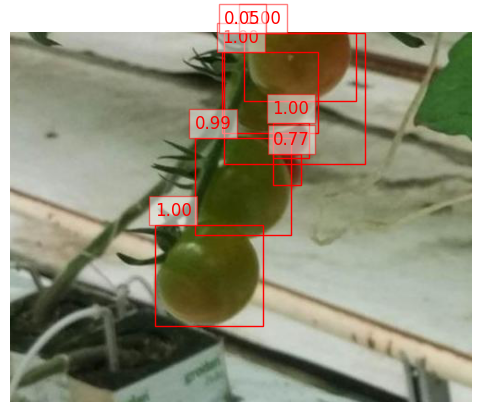

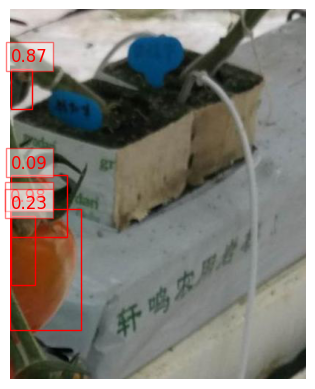

In [ ]:
def get_random_samples(data_loader, num_samples=2):
    dataset = data_loader.dataset
    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]
    images, targets = zip(*samples)
    return images, targets

random_images, _ = get_random_samples(test_loader, num_samples=2)

# Executar o modelo nas imagens aleatórias
random_outputs = model([img.to(device) for img in random_images])

# Visualizar os resultados
visualize_predictions(random_images, random_outputs)


## 6 - Análise dos resultados


*   mAP(Mean Average Precision) - 79,05%
*   Loss - Foi de 17,74% e estabilizou na época 9



